# Example Fe55 notebook

Initially written for the bootcamp at SLAC Nov 2018 by Simon Krughoff

### Setup

Before running this notebook, you'll need to set up the `obs_lsst` package. Before doing the setup procedure below, you might want to run the notebook until it crashes so you see what the error message looks like.

Step-by-step instructions:

1. Start a terminal in JupyterLab. In the terminal, setup the Stack with the command `source /opt/lsst/software/stack/loadLSST.bash` and then issue the command `setup lsst_distrib` to allow you to run scons in a subsequent step.

2. Create and/or switch into a folder where you want to put your local versions of the LSST Stack (e.g., `~/repos`)

Run the following commands

```
git clone https://github.com/lsst/obs_lsstCam.git
cd obs_lsstCam
setup -j -r .
scons
```

3. Add `setup -k -r path_to_repos/obs_lsstCam` to `$HOME/notebooks/.user_setups`.

4. Restart your kernel.

Just for fun, check what version of the Stack you are using. This notebook has been tested on `w_2018_45`.

In [ ]:
! eups list -s | grep lsst_distrib

### Imports

In [1]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
from scipy.optimize import leastsq
import numpy
import os

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.detection as afwDetection


# Firefly client imports
from firefly_client import FireflyClient
from IPython.display import IFrame

# ngmix
import emcee
import ngmix
from ngmix.fitting import MCMCSimple, print_pars
from ngmix.joint_prior import PriorSimpleSep
from ngmix.priors import CenPrior, FlatPrior, GPriorBA

import  numpy as np
import  pylab as pl
from matplotlib import cm
from numpy import log10, random
#from fit_constraints import ExamplePrior

In [2]:
class ExamplePrior(object):
    def __init__(self, log10Flux_range, log10T_range):
        self.log10Flux_range=log10Flux_range
        self.log10T_range=log10T_range

    def get_lnprob_scalar(self, pars):
        lnp=0.0
        logT=pars[4]
        if (logT < self.log10Flux_range[0]
                or logT > self.log10Flux_range[1]):
            lnp += -9.99e40
            #raise GMixRangeError("T is out of bounds")

        logFlux=pars[5]
        if (logFlux < self.log10Flux_range[0]
                or logFlux > self.log10Flux_range[1]):
            lnp += -9.99e40
            #raise GMixRangeError("flux is out of bounds")
        return lnp
    
    def fill_fdiff(self, pars, fdiff):
        from ngmix import GMixRangeError

        fdiff[0:4]=0.0
        logT=pars[4]
        if (logT < self.log10Flux_range[0]
                or logT > self.log10Flux_range[1]):
            fdiff[4] = -9.99e40
            #raise GMixRangeError("T is out of bounds")

        logFlux=pars[5]
        if (logFlux < self.log10Flux_range[0]
                or logFlux > self.log10Flux_range[1]):
            fdiff[5] = -9.99e40
            #raise GMixRangeError("flux is out of bounds")

        return 4

In [22]:
import sys

def imprint(im, stream=sys.stdout, fmt=None):
    if len(im.shape) != 2:
        raise ValueError("image must be 2-dimensional")

    if fmt is None:
        if im.dtype.char in ['f','d']:
            fmt = '%+e'
        else:
            maxint = im.max()
            minint = im.min()
            l = max( len(str(maxint)), len(str(minint)) )
            fmt = '%'+str(l)+'d'

    nrow = im.shape[0]
    ncol = im.shape[1]

#    for row in xrange(nrow):
    for row in range(nrow):
#        for col in xrange(ncol):
        for col in range(ncol):
            stream.write(fmt % im[row,col] )
            if col < (ncol-1):
                stream.write(" ")
        stream.write("\n")

In [3]:
def srandu(num=None):
#  Generate random numbers in the symmetric distribution [-1,1]
    return 2*(np.random.random(num)-0.5)

### Set up the config for the ISR task.  This essentially turns off all processing other than overscan and bias correction.

In [4]:
isr_config = IsrTask.ConfigClass()

isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doAddDistortionModel=False
isr_config.doLinearize=False

### Construct the `IsrTask` with the above configuration

In [5]:
isr = IsrTask(config=isr_config)

### Retrieve the data necessary to perform ISR.  This is just the raw data and the bias frame.  Note there are multiple integrations.  This notebook only looks at one of them.

In [54]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
print(butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FE55', 'testType': 'FE55'}))

dId = {'visit': 258334666, 'detector': 2}
raw = butler.get('raw', **dId)
bias = butler.get('bias', **dId)

[258334666, 258334978, 258335291, 258335602, 258335913]


In [55]:
result = isr.run(raw, bias=bias)

### Set up the necessary classes for using firefly to look at the data.

In [8]:
my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'


ff='{}/firefly/slate.html?__wsch={}'.format(server, my_channel)
IFrame(ff,800,600)

In [ ]:
afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, 
                                    name=my_channel)

### Disaplay the frame after ISR

In [ ]:
#afw_display.mtv(result.exposure)

### Set up the functions doing the fit

In [9]:
def double_gaussian(x, params):
    (c1, mu1, sigma1, c2, mu2, sigma2) = params
    res =  c1 * numpy.exp(-(x - mu1)**2.0/(2.0 * sigma1**2.0)) \
          + c2 * numpy.exp(-(x - mu2)**2.0/(2.0 * sigma2**2.0))
    return res

def double_gaussian_fit(params, x, y):
    fit = double_gaussian( x, params )
    return (fit - y)

### Loop over amps and fit a double gaussian to the distribution of counts in detections

In [56]:
xs = []
ys = []
fits = []
detector = result.exposure.getDetector()
aa = 0 
for amp in detector:
    aa = aa+1
    print('amp=', aa)
    if aa>1: break
    
    masked_img = result.exposure.getMaskedImage()
    work_img = masked_img[amp.getBBox()]
    arr = work_img.getImage().getArray()
    
    bkgd = numpy.median(arr) # estimate a background and subtract it
    arr -= bkgd

    thresh = afwDetection.Threshold(100)
    fs = afwDetection.FootprintSet(work_img, thresh) # detect hits
    fs = afwDetection.FootprintSet(fs, 2, False) # grow the detection footprints
    fs.makeHeavy(work_img)

    foots = fs.getFootprints()

    nn = 0
    counts = []
    sigma = []
    for foot in foots:
        nn = nn+1
        if nn>500: break
        if foot.getImageArray().size < 25:  # throw out big footprints/CRs since we know the hits should be in a single pixel modulo the charge diffusion.
            intens = np.sum(foot.getImageArray())
            counts.append(intens)
            centroid_x, centroid_y = foot.getCentroid()

            # get stamps for Erin's sub-sampling
            box = foot.getBBox()
            xmin = box.getMinX()
            xmax = box.getMaxX()
            ymin = box.getMinY()
            ymax = box.getMaxY()
#            im = image.getArray().transpose()
#            stamp = arr[xmin:xmax+1, ymin:ymax+1]
            stamp = arr[ymin:ymax+1, xmin:xmax+1]

#            print(xmin, xmax, ymin, ymax)
#            print(centroid_x, centroid_y, intens)
#            print(stamp)
#            print(foot.getImageArray())
            
# start using Erin's package               
            model="gauss"
    
# create a weight map (just 1/noise^2 for all pixels for now)
            noise = 0*stamp + 3
            weight_map = 1/noise**2
           
# create an Observation object.  Only image and weight for now
            obs = ngmix.observation.Observation(stamp, weight=weight_map)
            
# parameters for the MCMC fitter
            nwalkers =  80
            burnin =    400
            nstep =     400
            npars =     6
# use 4x4 sub-pixels for fit
            nsub =      4

# make a guess for [cen1,cen2,g1,g2,T,flux] where T is 2*sigma**2
            guess=np.zeros( (nwalkers, npars) )
            guess[:,0] = centroid_x - xmin + 0.1*srandu(nwalkers)
            guess[:,1] = centroid_y - ymin + 0.1*srandu(nwalkers)
            guess[:,2] = 0. + 0.1*srandu(nwalkers)
            guess[:,3] = 0. + 0.1*srandu(nwalkers)
            guess[:,4] = 0.32 * (1.0 + 0.1*srandu(nwalkers)) # 0.32 = 2*(0.4)**2
            guess[:,5] = intens * (1.0 + 0.1*srandu(nwalkers))

# prior on the center is 2d gaussian (x, y, x_width, y_width)
            cen_prior=CenPrior(3.0, 3.0, 1., 1.)

# prior on g is 2d gaussian (g1, g2, g1_width, g2_width)
            g_prior=ngmix.priors.ZDisk2D(1.0)
#            g_prior=GPriorBA(0.001)

# priors on T and F are flat between 0 and max.
            T_prior=FlatPrior(0., 1.)
            F_prior=FlatPrior(1000., 5000.)

            prior=PriorSimpleSep(cen_prior, g_prior, T_prior, F_prior)
        
# run the fitter
            mc  = MCMCSimple(obs, model, prior=prior, nwalkers=nwalkers, nsub=nsub)
#           mc  = MCMCSimple(obs, model, nwalkers=nwalkers, nsub=nsub)
                    
            pos = mc.run_mcmc(guess, burnin)
            pos = mc.run_mcmc(pos,   nstep)
            mc.calc_result()
            result = mc.get_result()
#           print(result)

# save also a random trial 
            trials = mc.get_trials()
            rint = np.random.randint(low=0, high=nstep)
            result['rand_pars'] = trials[rint, :].copy()
               
            print("----------------> event", nn)
#            imprint(stamp, fmt='%7.1f')
#            print_pars(result['pars'],     front='pars:')
#            print_pars(result['pars_err'], front='err: ')
#            print_pars(result['rand_pars'], front='rand_pars: ')
#            print('chi2per:',result['chi2per'])
#            print('arate:', result['arate'])
            TT = result['pars'][4]
            Sigma = np.sqrt(TT/2.)
#            print('sigma=', Sigma)
            sigma.append(Sigma)


#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Max L fitter below
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

# fit with 16x16 sub-pixel sampling
#            nsub=16
    
# parameters for the maximum likelihood fitter
#            lm_pars={'maxfev':500,
#                     'ftol':1.0e-6,
#                     'xtol':1.0e-6,
#                     'epsfcn': 1.0e-6}

# constrain T and Flux to be in certain ranges
#            log10T_range=[log10(2*0.1**2), log10(2*10.0**2)]
#            log10Flux_range=[log10(2000), log10(2600)]
#            prior=ExamplePrior(log10T_range,log10Flux_range)

# do not constrain        
#            prior=None
#            fitter=ngmix.fitting.LMSimple(obs, model, nsub=nsub, lm_pars=lm_pars, prior=prior)
                    
# make a guess for [cen1,cen2,g1,g2,T,flux] where T is 2*sigma**2
#            cen1 = centroid_x - xmin + 0.1 * (np.random.random()-0.5)
#            cen2 = centroid_y - ymin + 0.1 * (np.random.random()-0.5)
#            g1=0.
#            g2=0.
#            T_guess = 0.32 # = 2*(0.4)**2
#            flux_guess=intens

#            print(cen1, cen2, flux_guess)
            
#            guess=np.array( [cen1,cen2,g1,g2,T_guess,flux_guess] )
#            guess=np.array( [cen1,cen2,g1,g2,log10(T_guess),log10(flux_guess)] )

    
# run the fitter
#            fitter.run_lm(guess)
#            result=fitter.get_result()
#            print("best fit parameters:",result['pars'])
#            print("err on parameters:  ",result['pars_err'])
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

# histogramming

    hist = numpy.histogram(sigma, bins=2100.+numpy.array(range(80))*10.) # generate distribution to fit

    y = hist[0]
    x = [(hist[1][i]+hist[1][i+1])/2 for i in range(len(hist[1])-1)]

    fit = leastsq(double_gaussian_fit, [50.,2270.,50.,10.,2550.,40.], args=(x, y)) # starting parameters were determined by examining a representative distribution
    xs.append(x)
    ys.append(y)
    fits.append(fit)

amp= 1
----------------> event 1
----------------> event 2
----------------> event 3
----------------> event 4
----------------> event 5
----------------> event 6
----------------> event 7
----------------> event 8
----------------> event 9
----------------> event 10
----------------> event 11
----------------> event 12
----------------> event 13
----------------> event 14
----------------> event 16
----------------> event 19
----------------> event 21
----------------> event 22
----------------> event 26
----------------> event 27
----------------> event 31
----------------> event 32
----------------> event 33
----------------> event 34
----------------> event 35
----------------> event 36
----------------> event 39
----------------> event 41
----------------> event 42
----------------> event 44
----------------> event 45
----------------> event 46
----------------> event 47
----------------> event 48
----------------> event 50
----------------> event 51
----------------> event 52
---

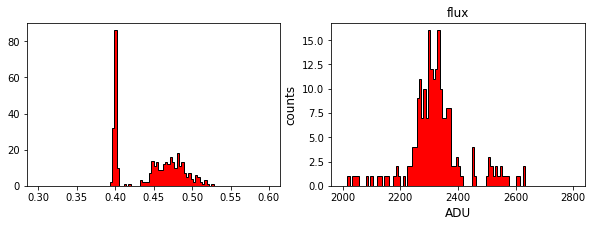

In [60]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 3))

ax0.hist(sigma, bins = 100, range = (0.3, 0.6), color = 'r', ec = 'k', histtype = 'stepfilled')
plt.title("sigma", fontsize = 12)
plt.xlabel('sigma, pix',fontsize = 12)
plt.ylabel('counts',fontsize = 12)

ax1.hist(counts, bins = 100, range = (2000., 2800.), color = 'r', ec = 'k', histtype = 'stepfilled')
plt.title("flux", fontsize = 12) # change the title
plt.xlabel('ADU',fontsize = 12)
plt.ylabel('counts',fontsize = 12)

plt.show()

### plot distributions for all 16 amps.

IndexError: list index out of range

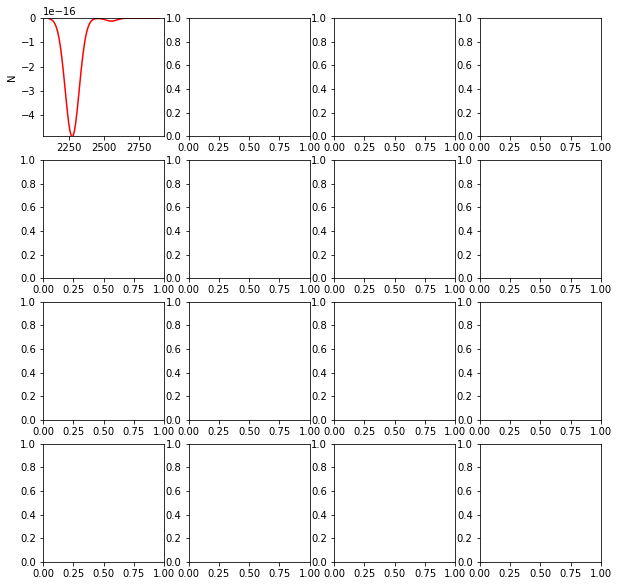

In [61]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    x = xs[i]
    y = ys[i]
    fit = fits[i]
    indx = i%4
    indy = i//4
    axs[indx][indy].bar(x, y, width=10)
    axs[indx][indy].plot(x, double_gaussian(x, fit[0]), c='r')
    if indx == 3:
        axs[indx][indy].set_xlabel('Counts (ADU)')
    if indy == 0:
        axs[indx][indy].set_ylabel('N')

In [ ]:
afw_display.mtv(work_img) # have a look at an example amp

In [ ]:
FE55_electrons = 1594

### Calculate gain and print them

In [ ]:
for i in range(16):
    print("Gain for amp %s -- %.5f"%(detector[i].getName(), FE55_electrons/fits[i][0][1]))